# Mental Health in the Tech Industry Analysis

## Imports

In [2]:
import pandas as pd
import sqlite3

## Sources and Links
Kaggle dataset : [Mental Health in the Tech Industry](https://www.kaggle.com/datasets/anth7310/mental-health-in-the-tech-industry)

Website used to create ERD : [dbdiagram.io](https://dbdiagram.io)

In [4]:
conn = sqlite3.connect('mental_health.sqlite')

In [5]:
tables_query = "select name from sqlite_master where type = 'table';"
tables = pd.read_sql(tables_query, conn)
tables

,name
0,Answer
1,Question
2,Survey


Here we have an `Entity Relationship Diagram` or `ERD` for short. This is a visual representation of how the tables in our SQL file are connected. Link above in the _sources and links_ section.

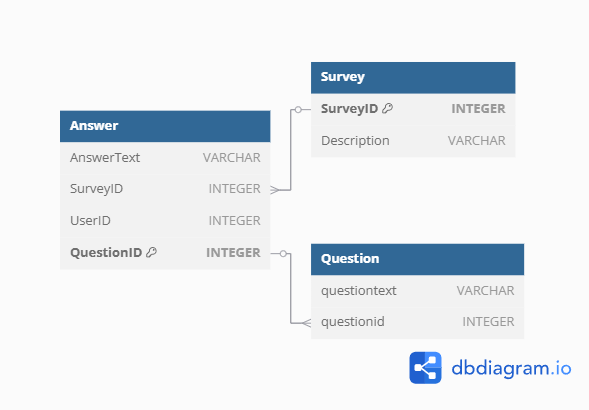

# Exploritory Data Analysis

In [5]:
pd.read_sql('''
select *
from Question;
''', conn)

,questiontext,questionid
0,What is your age?,1
1,What is your gender?,2
2,What country do you live in?,3
3,"If you live in the United States, which state ...",4
4,Are you self-employed?,5
...,...,...
100,Do you think that team members/co-workers woul...,114
101,"If yes, what condition(s) have you been diagno...",115
102,"If maybe, what condition(s) do you believe you...",116
103,Which of the following best describes your wor...,117


In [6]:
pd.read_sql('''
select *
from Answer;
''', conn)

,AnswerText,SurveyID,UserID,QuestionID
0,37,2014,1,1
1,44,2014,2,1
2,32,2014,3,1
3,31,2014,4,1
4,31,2014,5,1
...,...,...,...,...
236893,Other,2016,2689,117
236894,Support,2016,2690,117
236895,Back-end Developer,2016,2691,117
236896,DevOps/SysAdmin,2016,2692,117


In [7]:
pd.read_sql('''
select *
from Survey;
''', conn)

,SurveyID,Description
0,2014,mental health survey for 2014
1,2016,mental health survey for 2016
2,2017,mental health survey for 2017
3,2018,mental health survey for 2018
4,2019,mental health survey for 2019
